---
title: "Predict heart attack outcomes using decision tree classifier from scratch and scikit-learn"
description: Learn the k-Nearest Neighbors algorithm with me with a practical application on a dataset with diabetes patients   
date: "2023-03-01"
categories:
  - "Machine learning"
format: hugo-md
showTableOfContents: true
images:
  - /posts/classifier-decision-trees/index_files/card.jpg
aliases:
  - /classifier-decision-trees
---

While studying for my [IBM Data Science Profesional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) on Coursera, I came across decision trees - a robust classification and regression algorithm. Like k-Nearest Neighbors, decision trees are a shallow learning algorithm because they don’t require multi-layer modeling. In fact, like k-NN, decision trees also depend on how the algorithm will fit the features/dataset internally, so it can then make predictions on out-of-set data.

This post aims to look deeply at decision trees from a beginner’s angle: the theory, implementation from scratch, applying the algorithm to a problem/dataset, and evaluating its accuracy and performance. Ultimately, we will also compare my implementation of decision trees against the one shipped with scikit-learn.

Before we begin, it's worth noting that decision trees can be used for both, classification and regression problems. Here I will explore only classification and look into regression in another post.

Let's begin.

## Decision trees: 101

To understand decision trees better, we need to first figure out how they work on an abstract level. Let's look at this imaginary dataset:

In [841]:
import pandas as pd

data = {
    'age': [22, 45, 33, 28, 55, 65, 38, 24, 35, 42],
    'income': [25000, 50000, 75000, 40000, 90000, 120000, 60000, 30000, 80000, 95000],
    'bought': ['N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y']
}
dummy_df = pd.DataFrame(data)
dummy_df

,age,income,bought
0,22,25000,N
1,45,50000,Y
2,33,75000,Y
3,28,40000,N
4,55,90000,Y
5,65,120000,Y
6,38,60000,N
7,24,30000,N
8,35,80000,Y
9,42,95000,Y


It shows customer purchases of a particular product. Each observation contains the customer's age and income and whether they bought the product.How can we use this data to build a tree that, when provided with a customer's age and income, will predict whether they will buy the product or not?

Imagine we try to split the dataset into multiple parts and start with all observations - they all belong to the root node. We then ask the dataset a binary question for one of its features. Next, we split the observations of the dataset based on the answer to the question – the 'yes' rows go to the left node, and the 'no' rows go to the right node. We then create child nodes and assign them the rows for each of the 'yes' and 'no' rows. Finally, we continue this process recursively until we get to leaf nodes - nodes that are (mostly) pure (of the same class).

The steps outlined above are the process we go through when building decision trees. We split off the dataset into different branches, trying to get to a place where each leaf node is (almost) pure, or in other words, has all the rows belonging to the same class/label.

We're overlooking lots of important details here, but that's it in a nutshell. Visually, the decision tree for our dummy dataset would look like this:

![](index_files/decision-tree-graphic.png)

If we jump ahead and just use scikit-learn's `DecisionTreeClassifier`, make it fit our dummy dataset, and build a decision tree out of it, it would look like this:

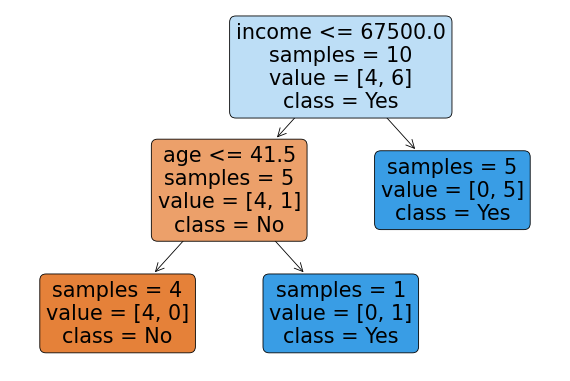

In [832]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert categorical variables to numerical using one-hot encoding
plot_df = pd.get_dummies(dummy_df, columns=['bought'])

# Create decision tree classifier
dtree = DecisionTreeClassifier()

# Fit the decision tree classifier on the data
X = plot_df.drop(['bought_N', 'bought_Y'], axis=1)
y = plot_df['bought_Y']
dtree.fit(X, y)

# Plot the decision tree
fig, ax = plt.subplots(figsize=(12, 8), dpi=60)
plot_tree(dtree, feature_names=X.columns, impurity=False, class_names=['No', 'Yes'], proportion=False, filled=True, ax=ax, label='all', rounded=True)
plt.show()


We can see that scikit-learn built a decision tree for us - it split off the dataset on the `income <= 67500` decision at the root node. Then, on the right side, it immediately got a pure node with the 'Yes' class, while on the left side, it needed another decision, this time on `age <= 41.5`. For the rows that answered 'No', it split those samples off to the left while the 'Yes' rows went to the right node.

We can see that each node has several samples assigned to it - those are the observations/rows of the dataset that went into that node. The label of each sample set to a node is the class that the node represents. And that's all about how decision tree work in theory. We'll dive into more details next, such as how we can choose what feature (e.g., `income`) and threshold (e.g., `67500`) to split our dataset on.

## Decision Trees, from scratch

Let's go through a rudimentary implementation of decision trees. At the beginning of this post, I put k-NN and decision trees in the same bucket, but that's deceiving. k-NN is simple; decision trees are complex. So make yourself a warm beverage and cozy up, as this post section will turn up the heat.

If you have a background in computer science, then this might be familiar: decision trees are a tree data structure, just on steroids. The different decision tree algorithms implement them as binary trees for practical reasons. In other words, every tree node will have a left and a right pointer to another node in the tree. So, a node will be a simple structure that will contain pointers to the left and right nodes, the feature that the node represents, its threshold (we'll see this in a bit), and the value/class of the node (only if a leaf node).

To implement decision trees, we'll need to implement the `fit` and `predict` methods (or their equivalents). Once invoked, the `fit` method will build out the whole decision tree based on the train data provided (features and labels). The decision tree algorithm is recursive by nature, so `fit` will recursively build the nested nodes and invoke itself for every next node it needs to make. `predict` will also need to recursively traverse the tree and return the classification based on the detected node.

I've seen many folks online tackling the decision tree algorithms in one go, which works fine. Still, I prefer to break it down to the core behaviors and components that allow decision trees to work as they do. Those are:

* Decision tree configuration, e.g., the allowed depth of the tree, splits per node, etc. 
* Building a binary tree using recursion, e.g., use correct stop criteria based on configuration and labels available
* Figuring out how to split a feature and on what thresholds. There are different decision tree algorithms, but in the one we'll cover, we'll look at information gain and entropy.

So, we will try to internalize these before we look at the algorithm as a whole. And we'll go in reverse order.

## Feature splitting

Using our initial example of customer characteristics and whether they have purchased an item, we must figure out how to build the tree. To make a decision node, we must find the feature to split the dataset (e.g., `Income`) and its threshold (e.g., `67500`). To get both, we must get all the features and labels and measure the point at which we want to perform the split.

Let's say we have the data frame from before:

In [842]:
dummy_df = pd.get_dummies(dummy_df, columns=['bought']).drop(columns=['bought_N']).rename(columns={'bought_Y': 'bought'})
dummy_df

,age,income,bought
0,22,25000,0
1,45,50000,1
2,33,75000,1
3,28,40000,0
4,55,90000,1
5,65,120000,1
6,38,60000,0
7,24,30000,0
8,35,80000,1
9,42,95000,1


To determine whether to use `age` or `income` and which threshold, we need to loop through each feature (`age` and `income`) and figure out the information gain between the feature and the target label (`bought`). Once we find the best gain from all the features, we will split the dataset on that feature with the found threshold.

Let's write this algorithm out. First, let's calculate information gain. Let's say we want to split our data on the `age` feature, with the threshold of `40`. In other words, we will split the above dataset into two parts: a part that contains all rows where `age <= 40` and another part that contains all rows where `age > 40`.

In [512]:
left_df = dummy_df[dummy_df['age'] <= 40]
left_df

,age,income,bought
0,22,25000,0
2,33,75000,1
3,28,40000,0
6,38,60000,0
7,24,30000,0
8,35,80000,1


In [513]:
right_df = dummy_df[dummy_df['age'] > 40]
right_df

,age,income,bought
1,45,50000,1
4,55,90000,1
5,65,120000,1
9,42,95000,1


If we look at the target value, we'll see that in the `right_df`, all rows contain `bought = 1`. But, in the `left_df`, we see a combination: four zeroes and two ones.

So was splitting the data on the `age` feature and threshold of `40` the right move? There's only one way to know: repeat the same process for all features and labels. But, even if we do that, we need a singular metric to compare across the different splits. Entropy and information gain are such metrics to aid us in the comparison.

Entropy in a collection describes the average level of information disorder or uncertainty. If you'd like to oversimplify it, it's a metric explaining how messy the data is. On the other hand, information gain is the opposite of entropy - when entropy decreases, information gain increases. Information gain computes the difference in entropy before the split and average entropy after the dataset split based on given attribute values. 

In other words, to know if the `age <= 40` is the right split, we need to measure the disorder in the target variable (`bought`) before and after the split. If the entropy decreases, then the information gain will increase.

Let's see this in action:

In [500]:
def calculate_entropy(collection):
    ps = np.bincount(collection) / len(collection)
    return -1 * np.sum([p * np.log(p) for p in ps if p > 0])

The `calculate_entropy` method takes a `collection` (e.g. a list) as an argument and calculates the collection's entropy. It does that by using the classic entropy forula:

$$S = -\sum_{i=1}^{n} p_i \ln{p_i}$$

If you prefer something other than mathematical notation, the Python code above should be of help. The entropy formula is the sum of the probabilities of each item in the collection multiplied by the natural logarithm of the probability of each item. 

In the Python method `calculate_entropy`, Numpy's `bincount` method counts the occurrences of each item in the collection. Once we divide each count by the collection length, we get the probability for each item in the collection. From there on, we continue applying the formula by summing each probability's multiplication with the probability's natural logarithm. Finally, before returning the sum, we multiply it by -1, which is the last step of the formula.

Now that we have a reliable way to calculate entropy, we need to figure out how to calculate information gain. Remember, information gain is the reverse of entropy - as the entropy decreases, the information gain increases. So, to calculate information gain, we have to figure out the entropy of the data at a node before splitting it, then calculate the entropy of the children nodes after splitting their parent, and then subtract the children's entropy from the parent entropy - that will be the information gain. In other words, by subtracting the parent and the children's entropy, we calculate which direction the entropy moved after the parent node got split.

Can we find where to split the data into the children nodes? The answer is: yes, by brute forcing. We will take the whole dataset, and for each row, we will split off the dataset into two, calculate the information gain, go to the next row and split off the dataset into two again, and then calculate the information gain again, and so on until we find the best information gain. The index at which we find the best information gain is the index at which we will split the dataset.

Let's see this in code:

In [843]:
X = dummy_df.loc[:, ['age', 'income']]
y = dummy_df.loc[:, 'bought']

First, we are splitting our dummy dataset into the features (`X`) and the target labels (`y`). Next, we will only use the `age` column to figure out what is the best place to split it, or in other words, at what index is the information gain highest.

In [844]:
# Find the best split for 'age' column
X_age = X.loc[:, 'age']

# Get unique values, as checking for the same threshold N times is wasteful
thresholds = np.unique(X_age)

for threshold in thresholds:
    # Calculate entropy before split on 'age' and '40'
    parent_entropy = calculate_entropy(y)
    
    # Split!
    left_X = X_age[X_age <= threshold]
    left_idx = left_X.index.to_list()

    right_X = X_age[X_age > threshold]
    right_idx = right_X.index.to_list()
    
    left_y, right_y = y.loc[left_idx], y.loc[right_idx]
    
    left_entropy, right_entropy = calculate_entropy(left_y), calculate_entropy(right_y)
    children_entropy = (len(left_y)/len(y)) * left_entropy + (len(right_y)/len(y)) * right_entropy
    
    information_gain = parent_entropy - children_entropy
    
    print(f"Threshold: {threshold} - Parent entropy: {parent_entropy} - Children entropy: {children_entropy} - Information gain: {information_gain}")

Threshold: 22 - Parent entropy: 0.6730116670092565 - Children entropy: 0.5728627514653315 - Information gain: 0.10014891554392502
Threshold: 24 - Parent entropy: 0.6730116670092565 - Children entropy: 0.44986811569504664 - Information gain: 0.22314355131420988
Threshold: 28 - Parent entropy: 0.6730116670092565 - Children entropy: 0.28708142280188625 - Information gain: 0.38593024420737027
Threshold: 33 - Parent entropy: 0.6730116670092565 - Children entropy: 0.4952707831673061 - Information gain: 0.17774088384195041
Threshold: 35 - Parent entropy: 0.6730116670092565 - Children entropy: 0.5867070452737222 - Information gain: 0.08630462173553433
Threshold: 38 - Parent entropy: 0.6730116670092565 - Children entropy: 0.38190850097688767 - Information gain: 0.29110316603236885
Threshold: 42 - Parent entropy: 0.6730116670092565 - Children entropy: 0.47803567329033014 - Information gain: 0.19497599371892638
Threshold: 45 - Parent entropy: 0.6730116670092565 - Children entropy: 0.5545177444479

Evindently, if we ask the `age` column it will tell us that the best place to split the dataset at is on the row where the `age` has the value of `28`. In other words, feature to split at is `age` and the threshold is `28`.

We can repeate the same exercise for the `income` column:

In [845]:
# Find the best split for 'income' column
X_income = X.loc[:, 'income']

# Get unique values, as checking for the same threshold N times is wasteful
thresholds = np.unique(X_income)

for threshold in thresholds:
    # Calculate entropy before split on 'income'
    parent_entropy = calculate_entropy(y)
    
    # Split!
    left_X = X_income[X_income <= threshold]
    left_idx = left_X.index.to_list()

    right_X = X_income[X_income > threshold]
    right_idx = right_X.index.to_list()
    
    left_y, right_y = y.loc[left_idx], y.loc[right_idx]
    
    left_entropy, right_entropy = calculate_entropy(left_y), calculate_entropy(right_y)
    children_entropy = (len(left_y)/len(y)) * left_entropy + (len(right_y)/len(y)) * right_entropy
    
    information_gain = parent_entropy - children_entropy
    
    print(f"Threshold: {threshold} - Parent entropy: {parent_entropy} - Children entropy: {children_entropy} - Information gain: {information_gain}")

Threshold: 25000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.5728627514653315 - Information gain: 0.10014891554392502
Threshold: 30000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.44986811569504664 - Information gain: 0.22314355131420988
Threshold: 40000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.28708142280188625 - Information gain: 0.38593024420737027
Threshold: 50000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.4952707831673061 - Information gain: 0.17774088384195041
Threshold: 60000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.25020121176909393 - Information gain: 0.4228104552401626
Threshold: 75000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.38190850097688767 - Information gain: 0.29110316603236885
Threshold: 80000 - Parent entropy: 0.6730116670092565 - Children entropy: 0.47803567329033014 - Information gain: 0.19497599371892638
Threshold: 90000 - Parent entropy: 0.6730116670092565 - Children 

The same exercise again: asking the `income` column where to split will tell us that the row where the `income` has the value of `60000` is the best place to split the data. If we compare the best information gains of the `income` and `age` columns, we'll find out that the information gain on the `income` split is higher than the `age` split. Therefore, the first split we should perform on our data is on the `income < 60000` threshold.

So now that we have applied the same algorithm to calculate the different entropies and information gain, let's generalize the code so it can find the best feature and threshold across multiple features:

In [846]:
def find_best_split(X, y, feat_idxs):
    best_gain = -1
    best_feature_idx, best_threshold = -1, -1
    
    for feat_idx in feat_idxs:
        X_column = X[:, feat_idx]
        
        # Get unique values, as checking for the same threshold N times is wasteful
        thresholds = np.unique(X_column)
        
        # Calculate entropy before split on 'income'. Doing it here instead of on every loop.
        parent_entropy = calculate_entropy(y)

        for threshold in thresholds:
            # Split the column on the threshold
            left_X = np.where(X_column <= threshold)
            right_X = np.where(X_column > threshold)
    
            # Split the y, to two children splits
            left_y, right_y = y[left_X], y[right_X]
    
            # Calculate the entropy of the left and right children
            left_entropy, right_entropy = calculate_entropy(left_y), calculate_entropy(right_y)
            
            # Calculate the average weighted children entropy
            children_entropy = (len(left_y)/len(y)) * left_entropy + (len(right_y)/len(y)) * right_entropy
    
            # Calculate the information gain
            information_gain = parent_entropy - children_entropy
        
            if information_gain > best_gain:
                best_gain = information_gain
                best_feature_idx = feat_idx
                best_threshold = threshold
    
    return best_feature_idx, best_threshold

The `find_best_split` method has the same functionality as the previous examples, with the key difference in that it has the ability to loop through many features (e.g. both `age` and `income`) and find the best split across the different features.  

Now that we have the `find_best_split` method defined, let's test it again on the `dummy_df` dataframe:

In [847]:
X = dummy_df.loc[:, ['age', 'income']].to_numpy()
y = dummy_df.loc[:, 'bought'].to_numpy()

best_feature, best_threshold = find_best_split(X, y, [0, 1])

print(f"Best feature: {dummy_df.columns[best_feature]}")
print(f"Best threshold: {best_threshold}")

Best feature: income
Best threshold: 60000


Awesome, we got the same result – for our dummy data frame, the best first split is on the `income` feature at the `60000` threshold. In other words, the first step to build the decision tree is to split the dataset on the `income` feature and set its `threshold` to `60000`. We will then have to repeat the same process recursively for both sides of the split, effectively building the tree.

Let's see how we can use the `find_best_split` method while building a binary tree recursively.

## Building a tree

To build the tree, after getting the best feature and threshold for splitting, we need to use the feature and threshold to actually split the data and recursively continue to split the splits until it reaches the exit criteria. Which is what we'll look at next.

Recursion requires exit or stop criteria, which, when reached, will iterrupt the recursive process. For decision trees, the exit criteria will be to either set how deep the tree will go (i.e., how many levels it will have), how many features it can use to build the tree, or how many samples each node must have. So first, we can start with only a single exit criterion and build from there.

Looking at our dummy data, let's build see the next steps after the invocation of the `find_best_split` method:

In [848]:
X = dummy_df.loc[:, ['age', 'income']].to_numpy()
y = dummy_df.loc[:, 'bought'].to_numpy()

best_feature, best_threshold = find_best_split(X, y, [0, 1])

left_idxs = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
right_idxs = np.argwhere(X[:, best_feature] > best_threshold).flatten()

print(f"left idxs: {left_idxs}, right idxs: {right_idxs}")

left idxs: [0 1 3 6 7], right idxs: [2 4 5 8 9]


Now that we know the indexes of the rows that belong to the root's right and left child nodes let's prepare the child nodes. First, we will create a method `build_tree` that will take the `X` and `y` as arguments and will find the best feature/threshold pair; it will find the children node indices and then build the children nodes by recursively calling `build_tree`, with the subset of the `X` and `y' using the split indices:

In [849]:
def build_tree(X, y):
    best_feature, best_threshold = find_best_split(X, y)

    left_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() <= best_threshold).flatten()
    right_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() > best_threshold).flatten()

    left = build_tree(X.loc[left_idxs], y.loc[left_idxs])
    right = build_tree(X.loc[right_idxs], y.loc[right_idxs])

That's all. Now we have the `left` and `right` pointers to the children. And the subsequent calls to `build_tree` will continiously build the tree until it depletes all rows of the `X` and `y` dataframes.

Our approach is naive. If we'd run the code it would throw an out of bounds error because we never actually handle the exit criteria. Another problem is that even though we known how to identify the splits, we do not actually build a tree. The tree must be a data structure that later we can use for prediction making.

Let's define the data structure first, adapt our `build_tree` method, and then move on to the exit criteria.

In [850]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        # Decision node
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        
        # Leaf node
        self.value = value

The `TreeNode` class will encapsulate the data required to construct the tree. Among the `feature` and the `threshold` used for splitting the dataset, it will also have the links to the `right` and the `left` children nodes. If the node is a leaf node, then it will also contin a value which is the class that the feature tree will predict.

Let's throw our `TreeNode` in the mix:

In [851]:
def build_tree(X, y):
    best_feature, best_threshold = find_best_split(X, y)

    left_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() <= best_threshold).flatten()
    right_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() > best_threshold).flatten()
    
    left = build_tree(X.loc[left_idxs], y.loc[left_idxs])
    right = build_tree(X.loc[right_idxs], y.loc[right_idxs])

    return TreeNode(best_feature, best_threshold, left, right)

Awesome! But if would run the above method, we'll end up with an array indexing error. That's because we never check whether we've depleted the indexes before we go for another recursive call.

To stop this class of problem, we need to implement the exit criteria. First, let's start by having the option to set the maximum depth of the tree:

In [853]:
def build_tree(X, y, current_depth, max_depth):
    if current_depth >= max_depth:
        counter = Counter(y)
        most_common_label = counter.most_common(1)[0][0]
        return TreeNode(value=most_common_label)
    
    best_feature, best_threshold = find_best_split(X, y)

    left_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() <= best_threshold).flatten()
    right_idxs = np.argwhere(X.loc[:, best_feature].to_numpy() > best_threshold).flatten()
    
    left = build_tree(X.loc[left_idxs], y.loc[left_idxs], current_depth+1, max_depth)
    right = build_tree(X.loc[right_idxs], y.loc[right_idxs], current_depth+1, max_depth)

    return TreeNode(best_feature, best_threshold, left, right)

We added the `current_depth` and `max_depth` arguments to the `build_tree` method. The current depth is helpful for the recursion, so we can control at what depth each time we invoke the method. The maximum depth is valuable as the exit criteria, allowing us to control how deep the tree can branch out. In addition, the control of the depth is a powerful tool to prevent overfitting.

The rest of the `if` clause finds the most common label amongst the leftover labels (`y`). The `Counter` structure is useful for finding the most common item in a collection, which we then return as the `value` of a `TreeNode` - a leaf node!

We can also throw in other exit criteria, such as limiting the number of features we can use when building the decision tree. For example, say we have a dataset with many features - should we use them all? Some features are more valuable than the rest, and we should use only those while building the tree.

## Using a subset of features

We need to make more dramatic changes to the `build_tree` and `find_best_split` methods to control the features we will use when building the decision tree. First, in the `find_best_split` method, we need to select a subset of features instead of using all the columns of the dependent variables (`X`). To do that, we will need to take a random feature subset.

Instead of just `income` and `age`, imagine our dataset had more features such as  `income`, `age`, `education`, `married`, and `net_worth`; we could say that we want to use only a subset of them when building the decision tree. To do that, we would need to get a randomized subset using Numpy's `random.choice` method:

In [854]:
features = ['income', 'age', 'education', 'married', 'net_worth']
n_useful_features = 3 # Set as input to `build_tree`
repeat_features = False

np.random.choice(features, n_useful_features, repeat_features)

array(['age', 'education', 'net_worth'], dtype='<U9')

By having this randomized array of feature names, we can use it on the `X` dataframe and just select a subset of the features. This will allow us to experiment with different tree configurations and find the best performing tree.

Let's see that in action in our `build_tree` and `find_best_split` methods. We will need to add the feature randomization in the `build_tree` method:

In [855]:
def build_tree(X, y, current_depth = 0, max_depth = 5, n_useful_features = None):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))
    if n_useful_features == None: n_useful_features = n_features 
    
    if current_depth >= max_depth or n_labels == 1:
        counter = Counter(y)
        most_common_label = counter.most_common(1)[0][0]
        return TreeNode(value=most_common_label)
    
    # Select N random features
    feature_idxs = np.random.choice(n_features, n_useful_features, replace=False)
    
    # Pass the feature subset of the X dataframe as argument to find_best_split
    best_feature, best_threshold = find_best_split(X, y, feature_idxs)
    
    left_idxs = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
    right_idxs = np.argwhere(X[:, best_feature] > best_threshold).flatten()
    
    left = build_tree(X[left_idxs], y[left_idxs], current_depth+1, max_depth)
    right = build_tree(X[right_idxs], y[right_idxs], current_depth+1, max_depth)

    return TreeNode(best_feature, best_threshold, left, right)

### Minimum samples per split

The last optimization that we'll make to our decision tree algorithm is to provide the control of the minimum samples that a node should have before it can be split. Such a limitation will make our trees less prone to overfitting - by setting such a threshold our tree building algorithm will not overfit the leaf nodes and branches.

Let's add this last configuration to the `build_tree` method:

In [856]:
def build_tree(X, y, current_depth = 0, max_depth = 5, n_useful_features = None, min_samples_split=2):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))
    n_useful_features = n_features if not n_useful_features else min(n_features, n_useful_features)
    
    if (current_depth >= max_depth or n_labels == 1 or n_samples<min_samples_split):
        counter = Counter(y)
        most_common_label = counter.most_common(1)[0][0]
        return TreeNode(value=most_common_label)
    
    # Select N random features
    feature_idxs = np.random.choice(n_features, n_useful_features, replace=False)
    
    # Pass the feature subset of the X dataframe as argument to find_best_split
    best_feature, best_threshold = find_best_split(X, y, feature_idxs)
    
    left_idxs = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
    right_idxs = np.argwhere(X[:, best_feature] > best_threshold).flatten()
    
    left = build_tree(X=X[left_idxs], y=y[left_idxs], current_depth = current_depth+1, max_depth = max_depth, n_useful_features = n_useful_features, min_samples_split = min_samples_split)
    right = build_tree(X=X[right_idxs], y=y[right_idxs], current_depth = current_depth+1, max_depth = max_depth, n_useful_features = n_useful_features, min_samples_split = min_samples_split)

    return TreeNode(best_feature, best_threshold, left, right)

That's really it. With this addition we are able to control the amount of features used to build the decision tree.

The last bit now is to implement the `predict` method, which will do the actual prediction using the built tree.

## Predictions

To implement the `predict` method, we will need an algorithm that will walk through the tree based on some criteria, and once it reaches a leaf node to return the value of the leaf, which wil be the class that we're trying to predict.

Let's see it in action:

In [857]:
def predict(node, X):
    return np.array([traverse_tree(node, x) for x in X])

def traverse_tree(node, x):
    if node.value != None:
        return node.value

    if x[node.feature] <= node.threshold:
        return traverse_tree(node.left, x)
    return traverse_tree(node.right, x)

The algorithm here is quite simple: for every row of the input features, we will recursively traverse the tree and drill down until we run into a leaf node. Once we run into a leaf node we'll return just it's value, which is the target label. Let's use it on our dummy test set:

In [858]:
X = df.loc[:, ['age', 'income']].to_numpy()
y = df.loc[:, 'bought'].to_numpy()

root = build_tree(X, y, 0)
y_hat = predict(root, X)

accuracy = np.sum(y == y_hat) / len(y)
print(accuracy)

1.0


100% accuracy, wow! Don't be fooled by it; I am committing one of the cardinal sins of machine learning – using the same data to train and test our model. We need to split our dataset into a training and validation set, build the decision tree using the training set and then measure its accuracy with the validation set.

Let's use our decision tree algorithm on a real-life dataset!

## Predicting cardiac arrest

The [Heart Attack Analysis & Prediction Dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset) contains data relating to the patient's health condition and their heart attack outcome (i.e. whether they did have a heart attack or not). It contains a few features:

* `Age` - Age of the patient
* `Sex` - Sex of the patient
* `exang` - exercise induced angina (1 = yes; 0 = no)
* `caa` - number of major vessels (0-3)
* `cp` - Chest Pain type
* `trtbps` - resting blood pressure (in mm Hg)
* `chol` - cholestoral in mg/dl fetched via BMI sensor
* `fbs` - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
* `rest_ecg` - resting electrocardiographic results
* `thalach` - maximum heart rate achieved

The `target` column of the dataset is the dependent variable, or the heart attack outcome.

To download the dataset from Kaggle, we'll use the `opendataset` Python package:

In [533]:
!pip install opendatasets --quiet

In [646]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ilijaeftimov
Your Kaggle Key: ········


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.11k/4.11k [00:00<00:00, 1.55MB/s]

In [859]:
import pandas as pd
import numpy as np

In [860]:
cardiac_df = pd.read_csv('./heart-attack-analysis-prediction-dataset/heart.csv')

In [861]:
cardiac_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset is pretty small as it contains just over 300 observations:

In [862]:
cardiac_df.shape

(303, 14)

What is interesting to notice is that all columns contain numerical data, which is great for classifier trees. In cases where we'd have categorical data we'd need to convert/encode it to numerical, e.g., by using one-hot encoding. 

To build our classifier tree, first, we will split the columns of the dataset into labels (`y`) and features (`X`). Then, once we have those, we'll use sklearn's `train_test_split` function to split the dataset into training and validation sets.

We will build the tree with the `X_train` and `y_train` collections. Once created, we will run predictions using the `X_test` set, which will return the predictions. In the last step, we will measure accuracy to assess the model's performance.

Let's see it in action:

In [863]:
X = cardiac_df.loc[:, 'age':'thall'].to_numpy()
y = cardiac_df.loc[:, 'output'].to_numpy()

In [873]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

root = build_tree(X=X_train, y=y_train, current_depth = 0, min_samples_split=5)
y_hat = predict(root, X_test)

accuracy = np.sum(y_test == y_hat) / len(y_test)
print(accuracy)

0.8021978021978022


Pretty cool! Our decision tree implementation has an accuracy of ~80%. In other words, it will correctly predict a heart attack condition in 80% of the patients. We can test a few different configurations of the decision tree and see which one will perform best. The levers we can pull are the depth of the tree, the minimum samples per split, and the number of features to look at.

We can try a few different pairs of maximum depth and minimum samples per split to test the accuracy of each tree configuration:

In [866]:
X = cardiac_df.loc[:, 'age':'thall'].to_numpy()
y = cardiac_df.loc[:, 'output'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=31415)

best_accuracy = -1
best_max_depth = -1
best_min_samples_split = -1

for max_depth in range(3, 10):
    for min_samples_split in range(2, 10):
        root = build_tree(X=X_train, y=y_train, current_depth = 0, max_depth = max_depth, min_samples_split=min_samples_split)
        y_hat = predict(root, X_test)

        accuracy = np.sum(y_test == y_hat) / len(y_test)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            
print(f"Best configration: Max depth: {best_max_depth} \t Minimum samples split: {best_min_samples_split} \t Accuracy: {best_accuracy}")

Best configration: Max depth: 3 	 Minimum samples split: 2 	 Accuracy: 0.8131868131868132


In my dummy benchmark above, it seems that the configuration of `max_depth` set at 3 and `min_samples_split` set at 2 will produce the most accurate decision tree, with an accuracy of 0.813.

Let's compare the performance of my implementation with the one from scikit-learn:

In [874]:
from sklearn import tree

X = cardiac_df.loc[:, 'age':'thall'].to_numpy()
y = cardiac_df.loc[:, 'output'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=31415)

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = np.sum(y_test == pred) / len(y_test)
accuracy

0.8131868131868132

This is pretty cool to see! The `DecisionTreeClassifier` from scikit-learn, when using the same configuration as my implementation, is as accurate as my decision tree implementation.

Let's use the same tree visualization technique we used before and see the tree that scikit-learn built for the heart attack prediction decision tree:

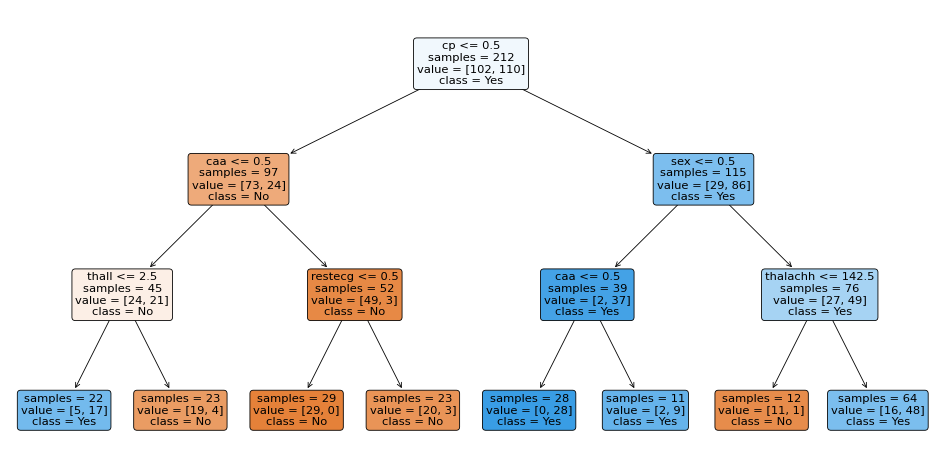

In [872]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

features = cardiac_df.loc[:, 'age':'thall'].columns

fig, ax = plt.subplots(figsize=(20, 10), dpi=60)
plot_tree(clf, 
          feature_names=features, 
          impurity=False, 
          class_names=['No', 'Yes'], 
          proportion=False, 
          filled=True, 
          ax=ax, 
          label='all', 
          rounded=True)
plt.show()

Seeing how scikit-learn's `DecisionTreeClassifier` fitted the data to a decision tree structure is fantastic. First, it split the data using the `cp` feature (chest pain type). Then on the left branch, it continued using `caa` (number of major vessels) and `restecg` (resting electrocardiographic results) to build the tree. On the right branch it used the `sex`, `caa`, and `thalachh` (maximum heart rate achieved) features.

After seeing how our implementation stacks against scikit-learn's, we're in an excellent place to conclude this deep-ish dive into using classifier decision trees. Now that we understand how decision trees work inside-out, we will revisit them soon with other powerful algorithms, such as Random Forests. 

## References

Some useful links that I used while writing this post:

* [Information gain (decision tree)](https://en.wikipedia.org/wiki/Information_gain_(decision_tree\)) on Wikipedia
* [Implementing a Decision Tree From Scratch](https://towardsdatascience.com/implementing-a-decision-tree-from-scratch-f5358ff9c4bb) on Towards Data Science
* [Why are implementations of decision tree algorithms usually binary and what are the advantages of the different impurity metrics?](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md) by Sebastian Raschka
* [Decision Tree implementation](https://github.com/AssemblyAI-Examples/Machine-Learning-From-Scratch/tree/main/04%20Decision%20Trees) by Misra Turp
* [Decision Tree Classification Clearly Explained!](https://www.youtube.com/watch?v=ZVR2Way4nwQ) by Normalized Nerd
* [Let’s Write a Decision Tree Classifier from Scratch - Machine Learning Recipes #8](https://www.youtube.com/watch?v=LDRbO9a6XPU) by Josh Gordon/Google
* [How to implement Decision Trees from scratch with Python](https://www.youtube.com/watch?v=NxEHSAfFlK8) by Misra Turp/AssemblyAI